In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import date, timedelta

import numpy as np
import pandas as pd
import jax.numpy as jnp

import mechafil.data as mecha_data
import mechafil.sim as np_sim

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu

import scenario_generator.utils as u
import scenario_generator.curated as curated

In [3]:
save_dir = '/Users/kiran/Documents/filp_saturation'
os.makedirs(save_dir, exist_ok=True)

In [4]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

start_date = date(2023, 7, 1)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*10
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-01 2023-07-25 2033-07-22


In [7]:
# get historical RBP, RR, FPR for last 180 days to setup simulation trajectories
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=365*2), current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=365*2), current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=365*2), current_date)

smoothed_last_historical_rbp = np.median(hist_rbp[-30:])
smoothed_last_historical_rr = np.median(hist_rr[-30:])
smoothed_last_historical_fpr = np.median(hist_fpr[-30:])


<IPython.core.display.Javascript object>


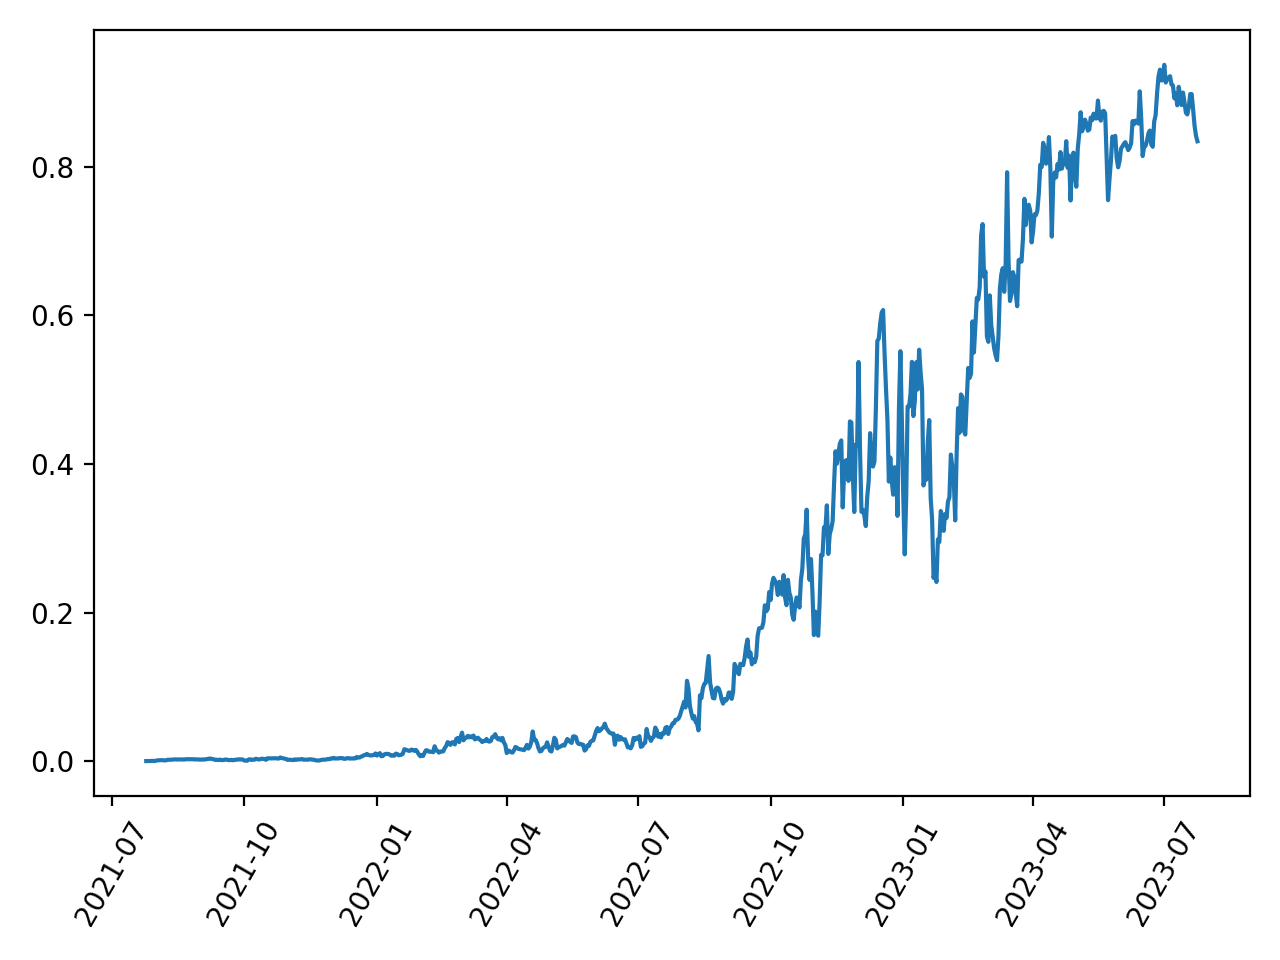

In [16]:
plt.figure()
plt.plot(t_hist_fpr, hist_fpr)
plt.xticks(rotation=60)
plt.tight_layout()

In [56]:
x = np.arange(0,len(hist_fpr)).astype(np.float64)
y = hist_fpr

In [101]:
import scipy.optimize as opt

def f2(x, L, k, x0):
    return L / (1. + np.exp(-k * (x - x0)))

def residuals(p, x, y):
    penalization = (p[0]-1)*10000
    return y - f2(x, p[0], p[1], p[2]) - penalization

In [102]:
(L_, k_, x0_), _ = opt.curve_fit(f2, x, y, 
                                 maxfev=5000, 
                                 p0=[1,1,1],
                                 bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))

In [103]:
popt2, pcov2 = opt.leastsq(func=residuals, x0=(1., 1., 1.), args=(x, y))

In [107]:
y_pred2 = f2(x, L_, k_, x0_)
y_pred3 = f2(x, *popt2)

<IPython.core.display.Javascript object>


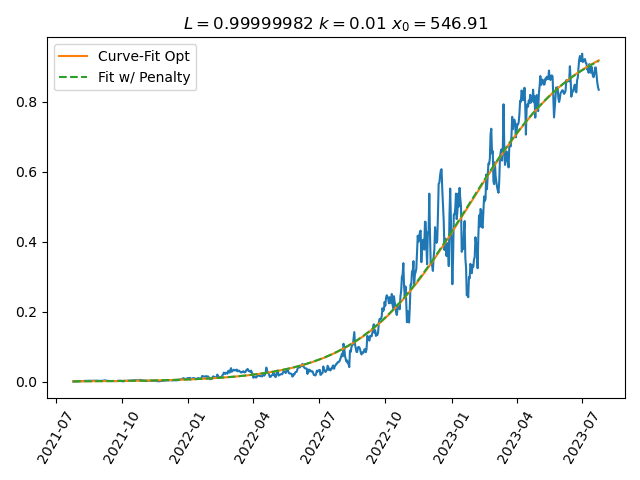

In [114]:
plt.figure()
plt.plot(t_hist_fpr, hist_fpr)
plt.plot(t_hist_fpr, y_pred2, label='Curve-Fit Opt')
plt.plot(t_hist_fpr, y_pred3, linestyle='--', label='Fit w/ Penalty')
plt.xticks(rotation=60)
plt.title(r'$L=%0.08f \ k=%0.02f \ x_0=%0.02f$' % (popt2[0], popt2[1], popt2[2]))
plt.legend()
plt.tight_layout()